<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/notebook/SeungTaek/two_stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers==2.3.0

     |████████████████████████████████| 447 kB 8.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.8 MB/s 
     |████████████████████████████████| 895 kB 51.1 MB/s 
     |████████████████████████████████| 132 kB 51.8 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 8.6 MB 16.7 MB/s 
     |████████████████████████████████| 138 kB 41.6 MB/s 
     |████████████████████████████████| 127 kB 58.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import pandas as pd # pandas 모듈 로드
import json  # json 모듈 로드
import re
import os
from glob import glob
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from google.colab import drive

from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from transformers import TextClassificationPipeline
from transformers import BertTokenizer, TFBertModel   #BERT
from tensorflow.keras.layers import Dense, Flatten

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -uq "/content/drive/MyDrive/AIFFEL/sns_train.zip" -d "/content/sns_data"

In [5]:
train_df = pd.read_csv("/content/drive/MyDrive/AIFFEL/train/train.csv")

In [6]:
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐?\n내 머리가 뭐.\n밥먹으면 대가리만 크냐 너는...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어. 살리고 싶으면 계좌에 1억만 보내\n예.?...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라. 어떻게 저렇게 살지.\n왜 그래. 들리겠어...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래?\n이게 무슨일입니까?\n남의 구역에서 장사하려면 자릿세...


In [7]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z가-힣0-9]+", " ", sentence)
    #sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣0-9?.!,\n]+", " ", sentence)
    #sentence = re.sub('\n'," "+"\n"+" ",sentence)

    sentence = sentence.strip()

    return sentence

In [8]:
train_df["conversation"] = train_df["conversation"].apply(preprocess_sentence)
train_df

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
3945,3945,기타 괴롭힘 대화,준하야 넌 대가리가 왜이렇게 크냐 내 머리가 뭐 밥먹으면 대가리만 크냐 너는 아니 ...
3946,3946,갈취 대화,내가 지금 너 아들 김길준 데리고 있어 살리고 싶으면 계좌에 1억만 보내 예 선생님...
3947,3947,직장 내 괴롭힘 대화,나는 씨 같은 사람 보면 참 신기하더라 어떻게 저렇게 살지 왜 그래 들리겠어 들리라...
3948,3948,갈취 대화,누구맘대로 여기서 장사하래 이게 무슨일입니까 남의 구역에서 장사하려면 자릿세를 내야...


In [9]:
def show_sentence_length(sentence_num, title, range_=[0, 500]):
    plt.figure(figsize=(13, 5))
    plt.suptitle(title, fontsize=14)
    
    plt.subplot(1, 2, 1)
    plt.hist(sentence_num, bins=range_[1], range=range_, facecolor='b', label='train')
    plt.xlabel('Number of question')
    plt.ylabel('Count of question')
    
    plt.subplot(1, 2, 2)
    plt.boxplot(sentence_num, labels=['token counts'], showmeans=True)

    plt.show()
    
    print("< Sentence Info >".center(100, "="))
    print(f"길이 최대:    {np.max(sentence_num):4d}")
    print(f"길이 최소:    {np.min(sentence_num):4d}")
    print(f"길이 평균:    {np.mean(sentence_num):7.3f}")
    print(f"길이 표준편차: {np.std(sentence_num):7.3f}", end="\n\n")
    
    percentile25 = np.percentile(sentence_num, 25)
    percentile50 = np.percentile(sentence_num, 50)
    percentile75 = np.percentile(sentence_num, 75)
    percentileIQR = percentile75 - percentile25
    percentileMAX = percentile75 + percentileIQR * 1.5
    
    print(f" 25/100분위:  {percentile25:7.3f}")
    print(f" 50/100분위:  {percentile50:7.3f}")
    print(f" 75/100분위:  {percentile75:7.3f}")
    print(f" MAX/100분위: {percentileMAX:7.3f}")
    print(f" IQR: {percentileIQR:7.3f}")
    print("=" * 100)

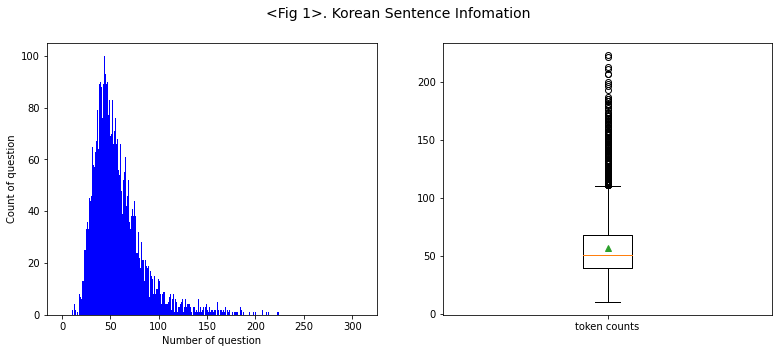

=========================================< Sentence Info >==========================================
길이 최대:     223
길이 최소:      10
길이 평균:     57.330
길이 표준편차:  27.040

 25/100분위:   40.000
 50/100분위:   51.000
 75/100분위:   68.000
 MAX/100분위: 110.000
 IQR:  28.000


In [10]:
sentence_counts = [len(text.split()) for text in train_df["conversation"]]

show_sentence_length(sentence_counts, "<Fig 1>. Korean Sentence Infomation", [0, 310])

In [11]:
data_path ="/content/sns_data/content/sns_csv_train"
files = glob(data_path + "/*")
files

['/content/sns_data/content/sns_csv_train/일과직업.csv',
 '/content/sns_data/content/sns_csv_train/미용과건강.csv',
 '/content/sns_data/content/sns_csv_train/상거래(쇼핑).csv',
 '/content/sns_data/content/sns_csv_train/개인및관계.csv',
 '/content/sns_data/content/sns_csv_train/주거와생활.csv',
 '/content/sns_data/content/sns_csv_train/시사교육.csv',
 '/content/sns_data/content/sns_csv_train/여가생활.csv',
 '/content/sns_data/content/sns_csv_train/식음료.csv',
 '/content/sns_data/content/sns_csv_train/행사.csv']

In [12]:

df_all = pd.DataFrame()
for i in files:
    df = pd.read_csv(i)
    df_all = pd.concat([df_all, df])


In [13]:
df_all["class"] = "일반 대화"

In [14]:
df_all.head()

,0,class
0,오빠 일 진짜 많네 돈 많이줌 ㅡㅡ?\n아니 ㅡㅡ 나진짜 심지어 내가 전에하던자리 ...,일반 대화
1,#@이름#이는 바1ㅡㄴ가봐 답장이 없오\n오늘부터 일하는겨?! 와..무슨 안전감시단...,일반 대화
2,아는언니가 승강기? 이쪽에 일하는데\n어 그언니한테 엘레베이터 관해서 물어봐바\n오...,일반 대화
3,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ\n진짜 답이없...,일반 대화
4,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 개막장이네 정말 오늘 11시에 과외하기로 햇는데\n또 취소함...,일반 대화


In [15]:
df_all = df_all.rename(columns = {'0' : "conversation"})

In [16]:
df_all = df_all[['class', 'conversation']]
df_all

,class,conversation
0,일반 대화,오빠 일 진짜 많네 돈 많이줌 ㅡㅡ?\n아니 ㅡㅡ 나진짜 심지어 내가 전에하던자리 ...
1,일반 대화,#@이름#이는 바1ㅡㄴ가봐 답장이 없오\n오늘부터 일하는겨?! 와..무슨 안전감시단...
2,일반 대화,아는언니가 승강기? 이쪽에 일하는데\n어 그언니한테 엘레베이터 관해서 물어봐바\n오...
3,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ\n진짜 답이없...
4,일반 대화,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ 개막장이네 정말 오늘 11시에 과외하기로 햇는데\n또 취소함...
...,...,...
141115,일반 대화,순천가서도 어디 들르기로했어?\nㅋㅋ어늘은.이게끝이야\nㅎㅎㅎ 그래 좋다 너무 늦게...
141116,일반 대화,아우어도 잠깐들려서 빵사서 호텔에서 먹어도된당 성수나 청담갈라면 지나서갈듯 ㅠ\n앙...
141117,일반 대화,너눈??\n나는 이제 집에가려구 버스 기다리고있어 우리 내일본다아아아아아아\n아항 ...
141118,일반 대화,ㅠ.ㅠ\n현대시키몰에서 살가요 걍\n거기가 젤 싸용? 아니면 당근은요?\n우리동네는...


In [17]:
df_train2 = df_all.sample(n = 4000, random_state = 6)

In [18]:
df_train2["conversation"] = df_train2["conversation"].apply(preprocess_sentence)
df_train2

,class,conversation
136459,일반 대화,시거잭이 모야 그 담배불 붗이는곳 그 충전기 연결되어 있는곳 알아 그 자동차 중간에...
21163,일반 대화,엄마가오늘저녁삼겹살이래 어떡할깡 오빠 오빠 수육이래 오빠 바뿐가 그럼내일보자 헤헤 ...
123758,일반 대화,수욜날 나가잠 왱 엥 왜냐니 아니 그날 비는거냐구 묻는 거임 네일 하자며 난 다 비어
17773,일반 대화,정신못차렸네 또 사치 뭔사치여 생일 날 먹고싶응거 시키라는데 웃겨증말 안통해요 난 ...
94112,일반 대화,이름 쌤 어제 검토했던거 혹시 내용 엑셀에 정리해두셨어여 폐업 3년 초과 확인하는 ...
...,...,...
46461,일반 대화,아 전정국 음 꾸기왜 어제 셔츠도 무신사 아 그래 심지어 깔별로 구매하신듯 기타 진...
53365,일반 대화,여러분 안녕 저 오늘 집을 계약하고 와쓰요 하 진짜 광란의 시간을 보냈지만 헤 일단...
18984,일반 대화,경력 15년이래 웅웅 마자 그래서 괜찮 느거같아 그럼 믿을만하지 않을깡 그리고 젊은...
409422,일반 대화,가서 뭐 좀 먹어 이 와중에 불닭볶음면 먹고 싶다 오 나도 먹을까 아니 내가 미안 ...


In [19]:
df_train2.to_csv("/content/drive/MyDrive/AIFFEL/sns_4000.csv")

In [20]:
df_train2.describe()

,class,conversation
count,4000,4000
unique,1,4000
top,일반 대화,시거잭이 모야 그 담배불 붗이는곳 그 충전기 연결되어 있는곳 알아 그 자동차 중간에...
freq,4000,1


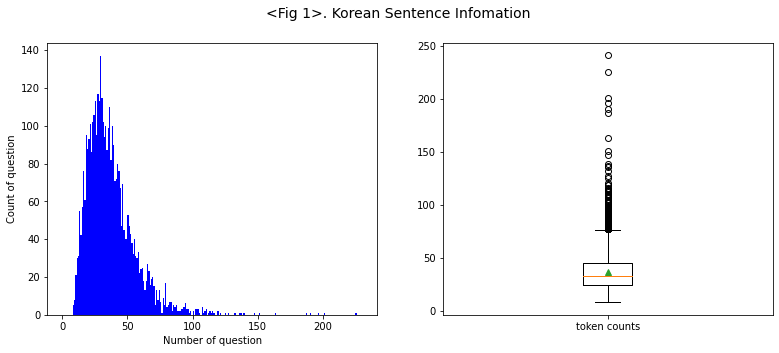

=========================================< Sentence Info >==========================================
길이 최대:     241
길이 최소:       8
길이 평균:     36.861
길이 표준편차:  19.325

 25/100분위:   24.000
 50/100분위:   33.000
 75/100분위:   45.000
 MAX/100분위:  76.500
 IQR:  21.000


In [21]:
sentence_counts_2 = [len(text.split()) for text in df_train2["conversation"]]

show_sentence_length(sentence_counts_2, "<Fig 1>. Korean Sentence Infomation", [0, 230])

In [22]:
df_train = pd.concat([train_df, df_train2])
df_train

,idx,class,conversation
0,0.0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1.0,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,2.0,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3.0,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4.0,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...,...
46461,NaN,일반 대화,아 전정국 음 꾸기왜 어제 셔츠도 무신사 아 그래 심지어 깔별로 구매하신듯 기타 진...
53365,NaN,일반 대화,여러분 안녕 저 오늘 집을 계약하고 와쓰요 하 진짜 광란의 시간을 보냈지만 헤 일단...
18984,NaN,일반 대화,경력 15년이래 웅웅 마자 그래서 괜찮 느거같아 그럼 믿을만하지 않을깡 그리고 젊은...
409422,NaN,일반 대화,가서 뭐 좀 먹어 이 와중에 불닭볶음면 먹고 싶다 오 나도 먹을까 아니 내가 미안 ...


In [23]:
df_train = df_train.drop(['idx'],axis=1)
df_train

,class,conversation
0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,협박 대화,길동경찰서입니다 9시 40분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 ...
2,기타 괴롭힘 대화,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,갈취 대화,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...
...,...,...
46461,일반 대화,아 전정국 음 꾸기왜 어제 셔츠도 무신사 아 그래 심지어 깔별로 구매하신듯 기타 진...
53365,일반 대화,여러분 안녕 저 오늘 집을 계약하고 와쓰요 하 진짜 광란의 시간을 보냈지만 헤 일단...
18984,일반 대화,경력 15년이래 웅웅 마자 그래서 괜찮 느거같아 그럼 믿을만하지 않을깡 그리고 젊은...
409422,일반 대화,가서 뭐 좀 먹어 이 와중에 불닭볶음면 먹고 싶다 오 나도 먹을까 아니 내가 미안 ...


In [24]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train

,class,conversation
0,일반 대화,꾹씨 오늘 신발 언박싱 혼자했네유 신고 출근했슈 에에 빠르누 우리집에 물건 사면 안...
1,기타 괴롭힘 대화,야 김이진 개 완전 못생겼지 않냐 그러니까 너무 못갱겼어 인정 야 뭐라했냐 너 못생...
2,일반 대화,내가 환승까지 못했으면 진짜 대분노야 내가 짐짜 교양있는거에 감사해랴 환승했어 다행...
3,기타 괴롭힘 대화,야 넌 왜 맨날 이상한 화장해 그런다고 남자애들이 너 안 좋아해 난 남자애들한테 잘...
4,일반 대화,재밌어 재미는 있는데 말이 안통해서 답답해 내가 번역 번역 해도 읽을줄 몰러 뭐라고...
...,...,...
7945,직장 내 괴롭힘 대화,저희 밥 먹으러 가요 좋아요 좋아 오늘 불고기 어때요 좋죠 다 같이 가는 건가요 네...
7946,일반 대화,너무 보고 싶어서 왜 여보여보 미칠 거 같아 나두 보고 잡다 다리가 너무 아파 내가...
7947,일반 대화,칭구가 아이폰 미니 22에 산다는데 성지에서 저기 어딘지 몰게쌈 나 저거 기타 에서...
7948,일반 대화,나 어제부터 다이어트 하려고 맘 먹었는데 자꾸 과장이 아침마다 먹을거 사와 나야 개...


In [25]:
df = pd.read_csv("/content/drive/MyDrive/AIFFEL/senti_kor_sns_5000_bt.csv")
df.head()

,Unnamed: 0,class,conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,0,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,1,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


협박 대화           3924
갈취 대화           4376
직장 내 괴롭힘 대화    15346
기타 괴롭힘 대화       3916
일반 대화           3584
Name: Unnamed: 0, dtype: int64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_

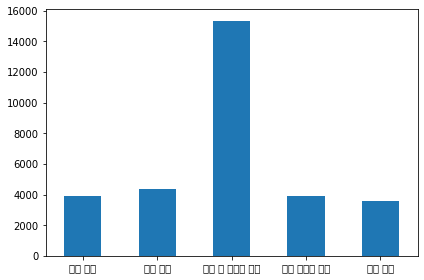

In [28]:
group_count = df.groupby("class").count().iloc[:,0]
group_count.index = label_names
print(group_count)
group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

In [27]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(df["class"]):
  if label == 0:
    bucket_class.append(label_names[0])
  elif label == 1:
    bucket_class.append(label_names[1])
  elif label == 2:
    bucket_class.append(label_names[2])
  elif label == 3:
    bucket_class.append(label_names[3])
  elif label == 4:
    bucket_class.append(label_names[4])

df["class"] = bucket_class
df.head()

,Unnamed: 0,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [29]:
bucket_class.count("일반 대화")

15346

In [30]:
df_train = df

In [31]:
def filt_sentence_length(df, col, sentence_len):
    df = df.copy()
    df["len"] = df[col].apply(lambda x: len(x.split()))
    df = df.loc[df["len"] < sentence_len]
    df.drop(["len"], axis="columns", inplace=True)
    return df
    
dataset = filt_sentence_length(df_train, "conversation", 128)

In [32]:
df_train["협박 대화"] = int(0)
df_train["갈취 대화"] = int(0)
df_train["직장 내 괴롭힘 대화"] = int(0)
df_train["기타 괴롭힘 대화"] = int(0)
df_train["일반 대화"] = int(0)
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,0,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,0,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,0,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,0,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,0,0,0,0


In [33]:
for idx, label in enumerate(df_train["class"]):
    if label == "협박 대화":
        df_train.loc[idx, "협박 대화"] = int(1)
    elif label == "갈취 대화":
        df_train.loc[idx, "갈취 대화"] = int(1)
    elif label == "직장 내 괴롭힘 대화":
        df_train.loc[idx, "직장 내 괴롭힘 대화"] = int(1)
    elif label == "기타 괴롭힘 대화":
        df_train.loc[idx, "기타 괴롭힘 대화"] = int(1)
    elif label == "일반 대화":
        df_train.loc[idx, "일반 대화"] = int(1)
df_train.head()

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,1,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,1,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,1,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,1,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,1,0,0,0


In [34]:
df_train

,Unnamed: 0,class,conversation,협박 대화,갈취 대화,직장 내 괴롭힘 대화,기타 괴롭힘 대화,일반 대화
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,1,0,0,0,0
1,1,협박 대화,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,1,0,0,0,0
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,0,0,0,1,0
3,3,갈취 대화,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,0,1,0,0,0
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,0,1,0,0,0
...,...,...,...,...,...,...,...,...
31141,31141,기타 괴롭힘 대화,"준샤, 왜 이렇게 큰 거야? 내 머릿속에 뭐가 들어있어? 큰 사람이라고 말하지 않았...",0,0,0,1,0
31142,31142,갈취 대화,"내가 지금 당신 아들을 데리고 있다면, 당신이 그를 구하려고 하면, 그냥 돈을 보내...",0,1,0,0,0
31143,31143,직장 내 괴롭힘 대화,당신 같은 사람을 보면 어떻게 이렇게 살 수 있을까요? 왜 그렇게 말하는 거죠? 지...,0,0,1,0,0
31144,31144,갈취 대화,"여기서 무슨 일을 하든 경찰에 신고하고 정식으로 사업을 해야 하는데, 어디든 우리 ...",0,1,0,0,0


In [35]:
group_count = df_train.groupby("class").count().iloc[:,0]
group_count

class
갈취 대화           3924
기타 괴롭힘 대화       4376
일반 대화          15346
직장 내 괴롭힘 대화     3916
협박 대화           3584
Name: Unnamed: 0, dtype: int64

In [36]:
number_min_label = min(group_count)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 3584


In [37]:
under_train = df_train.groupby("class").sample(number_min_label, random_state = 5)
under_train.groupby("class").count().iloc[:,0]

class
갈취 대화          3584
기타 괴롭힘 대화      3584
일반 대화          3584
직장 내 괴롭힘 대화    3584
협박 대화          3584
Name: Unnamed: 0, dtype: int64

In [38]:
df_train = under_train

In [39]:
model_name = 'bert-base-uncased'

In [40]:
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
MAX_LEN = 128

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        tokenized_sentence = tokenizer.encode(
                            sentence,                  # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_seq_len,  # Truncate all sentences.
                    )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        att_mask = [int(token_id > 0) for token_id in sentence]
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(df_train['conversation'], tokenizer, MAX_LEN)
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
attention_masks = create_attention_masks(input_ids)

100%|██████████| 17920/17920 [00:38<00:00, 465.01it/s]


In [41]:
labels =  df_train[label_names].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=0, test_size=0.1)

train_size = len(train_inputs)
validation_size = len(validation_inputs)

In [42]:
BATCH_SIZE = 16
NR_EPOCHS = 3

def create_dataset(data_tuple, epochs=1, batch_size=32, buffer_size=10000, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    if train:
        dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.repeat(epochs)
    dataset = dataset.batch(batch_size)
    if train:
        dataset = dataset.prefetch(1)
    
    return dataset

train_dataset = create_dataset((train_inputs, train_masks, train_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)
validation_dataset = create_dataset((validation_inputs, validation_masks, validation_labels), epochs=NR_EPOCHS, batch_size=BATCH_SIZE)

In [43]:
class BertClassifier(tf.keras.Model):    
    def __init__(self, bert: TFBertModel, num_classes: int):
        super().__init__()
        self.bert = bert
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    @tf.function
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        outputs = self.bert(input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids,
                               position_ids=position_ids,
                               head_mask=head_mask)
        cls_output = outputs[1]
        cls_output = self.classifier(cls_output)
                
        return cls_output

model = BertClassifier(TFBertModel.from_pretrained(model_name), len(label_names))

In [44]:
import time
from transformers import create_optimizer

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = validation_size // BATCH_SIZE

# | Loss Function
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=False)
train_loss = tf.keras.metrics.Mean(name='train_loss')
validation_loss = tf.keras.metrics.Mean(name='test_loss')

# | Optimizer (with 1-cycle-policy)
warmup_steps = steps_per_epoch // 3
total_steps = steps_per_epoch * NR_EPOCHS - warmup_steps
optimizer = create_optimizer(init_lr=2e-5, num_train_steps=total_steps, num_warmup_steps=warmup_steps)

# | Metrics
train_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_names))]
validation_auc_metrics = [tf.keras.metrics.AUC() for i in range(len(label_names))]

@tf.function
def train_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(token_ids, attention_mask=masks)
        loss = loss_object(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables), 1.0)

    train_loss(loss)

    for i, auc in enumerate(train_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
        
@tf.function
def validation_step(model, token_ids, masks, labels):
    labels = tf.dtypes.cast(labels, tf.float32)

    predictions = model(token_ids, attention_mask=masks, training=False)
    v_loss = loss_object(labels, predictions)

    validation_loss(v_loss)
    for i, auc in enumerate(validation_auc_metrics):
        auc.update_state(labels[:,i], predictions[:,i])
                                              
def train(model, train_dataset, val_dataset, train_steps_per_epoch, val_steps_per_epoch, epochs):
    for epoch in range(epochs):
        print('=' * 50, f"EPOCH {epoch}", '=' * 50)

        start = time.time()

        for i, (token_ids, masks, labels) in enumerate(tqdm(train_dataset, total=train_steps_per_epoch)):
            train_step(model, token_ids, masks, labels)
            if i % 1000 == 0:
                print(f'\nTrain Step: {i}, Loss: {train_loss.result()}')
                for i, label_name in enumerate(label_names):
                    print(f"{label_name} roc_auc {train_auc_metrics[i].result()}")
                    train_auc_metrics[i].reset_states()
        
        for i, (token_ids, masks, labels) in enumerate(tqdm(val_dataset, total=val_steps_per_epoch)):
            validation_step(model, token_ids, masks, labels)

        print(f'\nEpoch {epoch+1}, Validation Loss: {validation_loss.result()}, Time: {time.time()-start}\n')

        for i, label_name in enumerate(label_names):
            print(f"{label_name} roc_auc {validation_auc_metrics[i].result()}")
            validation_auc_metrics[i].reset_states()

        print('\n')

        
train(model, train_dataset, validation_dataset, train_steps_per_epoch=steps_per_epoch, val_steps_per_epoch=validation_steps, epochs=NR_EPOCHS)

================================================== EPOCH 0 ==================================================


  0%|          | 1/1008 [00:17<4:58:26, 17.78s/it]


Train Step: 0, Loss: 0.9748369455337524
협박 대화 roc_auc 0.0
갈취 대화 roc_auc 0.5583333373069763
직장 내 괴롭힘 대화 roc_auc 0.699999988079071
기타 괴롭힘 대화 roc_auc 0.2142857164144516
일반 대화 roc_auc 0.8589743375778198


 99%|█████████▉| 1001/1008 [04:28<00:01,  3.88it/s]


Train Step: 1000, Loss: 0.3819713890552521
협박 대화 roc_auc 0.7441155314445496
갈취 대화 roc_auc 0.8130115866661072
직장 내 괴롭힘 대화 roc_auc 0.8228152990341187
기타 괴롭힘 대화 roc_auc 0.7190966606140137
일반 대화 roc_auc 0.9308951497077942


2001it [08:38,  3.87it/s]


Train Step: 2000, Loss: 0.30930373072624207
협박 대화 roc_auc 0.8929325938224792
갈취 대화 roc_auc 0.9239886403083801
직장 내 괴롭힘 대화 roc_auc 0.9510300755500793
기타 괴롭힘 대화 roc_auc 0.8808245062828064
일반 대화 roc_auc 0.9923798441886902


3001it [12:49,  3.86it/s]


Train Step: 3000, Loss: 0.2606092691421509
협박 대화 roc_auc 0.9445488452911377
갈취 대화 roc_auc 0.9623069167137146
직장 내 괴롭힘 대화 roc_auc 0.9800516963005066
기타 괴롭힘 대화 roc_auc 0.9446847438812256
일반 대화 roc_auc 0.998591423034668


3024it [12:55,  3.90it/s]
336it [00:28, 11.74it/s]



Epoch 1, Validation Loss: 0.21995089948177338, Time: 803.9083824157715

협박 대화 roc_auc 0.9072860479354858
갈취 대화 roc_auc 0.9248874187469482
직장 내 괴롭힘 대화 roc_auc 0.969744086265564
기타 괴롭힘 대화 roc_auc 0.9035428166389465
일반 대화 roc_auc 0.9903903007507324


================================================== EPOCH 1 ==================================================


  0%|          | 1/1008 [00:00<05:06,  3.29it/s]


Train Step: 0, Loss: 0.2600833773612976
협박 대화 roc_auc 0.9249122142791748
갈취 대화 roc_auc 0.9416118860244751
직장 내 괴롭힘 대화 roc_auc 0.973329484462738
기타 괴롭힘 대화 roc_auc 0.9185308814048767
일반 대화 roc_auc 0.9992877244949341


 99%|█████████▉| 1001/1008 [04:11<00:01,  3.85it/s]


Train Step: 1000, Loss: 0.23086810111999512
협박 대화 roc_auc 0.9585752487182617
갈취 대화 roc_auc 0.9712212085723877
직장 내 괴롭힘 대화 roc_auc 0.9857333898544312
기타 괴롭힘 대화 roc_auc 0.9597940444946289
일반 대화 roc_auc 0.9991441369056702


2001it [08:21,  3.89it/s]


Train Step: 2000, Loss: 0.21328477561473846
협박 대화 roc_auc 0.9579018354415894
갈취 대화 roc_auc 0.9709614515304565
직장 내 괴롭힘 대화 roc_auc 0.9855497479438782
기타 괴롭힘 대화 roc_auc 0.9600086212158203
일반 대화 roc_auc 0.9991428852081299


3001it [12:32,  3.89it/s]


Train Step: 3000, Loss: 0.2016196995973587
협박 대화 roc_auc 0.9582473635673523
갈취 대화 roc_auc 0.970775306224823
직장 내 괴롭힘 대화 roc_auc 0.9854612350463867
기타 괴롭힘 대화 roc_auc 0.9595890045166016
일반 대화 roc_auc 0.9991501569747925


3024it [12:38,  3.99it/s]
336it [00:27, 12.31it/s]



Epoch 2, Validation Loss: 0.2199508547782898, Time: 785.6051535606384

협박 대화 roc_auc 0.9072860479354858
갈취 대화 roc_auc 0.9248874187469482
직장 내 괴롭힘 대화 roc_auc 0.969744086265564
기타 괴롭힘 대화 roc_auc 0.9035428166389465
일반 대화 roc_auc 0.9903903007507324


================================================== EPOCH 2 ==================================================


  0%|          | 1/1008 [00:00<05:02,  3.32it/s]


Train Step: 0, Loss: 0.20139887928962708
협박 대화 roc_auc 0.9621790051460266
갈취 대화 roc_auc 0.9690544009208679
직장 내 괴롭힘 대화 roc_auc 0.9841720461845398
기타 괴롭힘 대화 roc_auc 0.9588392376899719
일반 대화 roc_auc 0.9997841715812683


 99%|█████████▉| 1001/1008 [04:11<00:01,  3.86it/s]


Train Step: 1000, Loss: 0.19308333098888397
협박 대화 roc_auc 0.9582056403160095
갈취 대화 roc_auc 0.9709438681602478
직장 내 괴롭힘 대화 roc_auc 0.9855422973632812
기타 괴롭힘 대화 roc_auc 0.9597358703613281
일반 대화 roc_auc 0.9991459846496582


2001it [08:21,  3.89it/s]


Train Step: 2000, Loss: 0.1868179589509964
협박 대화 roc_auc 0.958111584186554
갈취 대화 roc_auc 0.9714358448982239
직장 내 괴롭힘 대화 roc_auc 0.9856331944465637
기타 괴롭힘 대화 roc_auc 0.9597004652023315
일반 대화 roc_auc 0.999138355255127


3001it [12:32,  3.87it/s]


Train Step: 3000, Loss: 0.18193425238132477
협박 대화 roc_auc 0.9581932425498962
갈취 대화 roc_auc 0.9708703756332397
직장 내 괴롭힘 대화 roc_auc 0.9856446385383606
기타 괴롭힘 대화 roc_auc 0.9600580930709839
일반 대화 roc_auc 0.9991472363471985


3024it [12:38,  3.99it/s]
336it [00:27, 12.31it/s]


Epoch 3, Validation Loss: 0.21995073556900024, Time: 785.3917322158813

협박 대화 roc_auc 0.9072860479354858
갈취 대화 roc_auc 0.9248874187469482
직장 내 괴롭힘 대화 roc_auc 0.969744086265564
기타 괴롭힘 대화 roc_auc 0.9035428166389465
일반 대화 roc_auc 0.9903903007507324




In [45]:
json_path = "/content/drive/MyDrive/AIFFEL/test/test.json"

df_test = pd.read_json(json_path, orient ='index')

In [46]:
df_test.head()

,text
t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...
t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...
t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...
t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...
t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...


In [47]:
test_input_ids = tokenize_sentences(df_test['text'], tokenizer, MAX_LEN)
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
test_attention_masks = create_attention_masks(test_input_ids)

100%|██████████| 500/500 [00:01<00:00, 381.07it/s]


In [48]:
TEST_BATCH_SIZE = 4
test_steps = len(df_test) // TEST_BATCH_SIZE

test_dataset = create_dataset((test_input_ids, test_attention_masks), batch_size=TEST_BATCH_SIZE, train=False, epochs=1)

In [49]:
pred = model.predict(test_dataset)
pred

array([[0.22845572, 0.6414801 , 0.01035569, 0.03343387, 0.00414167],
       [0.02336749, 0.04591299, 0.9401017 , 0.01179509, 0.00291288],
       [0.03096874, 0.14209208, 0.14866316, 0.44419968, 0.01927775],
       ...,
       [0.06769599, 0.8733125 , 0.02001376, 0.03550706, 0.01435816],
       [0.89848346, 0.01125578, 0.02628819, 0.03900154, 0.00409729],
       [0.21831056, 0.6494296 , 0.00296898, 0.01963292, 0.01675091]],
      dtype=float32)

In [50]:
pred = np.argmax(pred, axis = -1)
pred

array([1, 2, 3, 4, 4, 0, 0, 3, 4, 1, 0, 4, 2, 2, 2, 0, 4, 3, 0, 3, 0, 3,
       3, 3, 1, 2, 1, 1, 2, 4, 1, 1, 3, 2, 4, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       3, 2, 0, 0, 4, 0, 3, 3, 1, 2, 2, 3, 1, 3, 3, 3, 1, 3, 2, 3, 2, 0,
       4, 4, 4, 1, 4, 2, 3, 2, 3, 2, 3, 2, 2, 4, 0, 0, 4, 0, 3, 2, 0, 4,
       1, 2, 0, 2, 0, 4, 3, 2, 2, 3, 1, 2, 4, 1, 4, 2, 3, 2, 2, 3, 4, 0,
       4, 0, 3, 2, 1, 1, 4, 2, 2, 1, 2, 3, 1, 1, 1, 1, 2, 4, 1, 3, 3, 3,
       3, 3, 1, 0, 3, 0, 3, 4, 3, 4, 1, 3, 0, 0, 0, 3, 0, 1, 2, 3, 0, 4,
       4, 4, 0, 2, 4, 3, 3, 3, 4, 0, 2, 3, 2, 4, 3, 4, 3, 2, 2, 3, 1, 2,
       4, 2, 0, 3, 2, 3, 2, 4, 4, 1, 4, 4, 1, 3, 0, 3, 1, 1, 1, 1, 4, 4,
       0, 0, 2, 3, 3, 4, 0, 3, 2, 2, 2, 2, 4, 1, 3, 2, 1, 4, 3, 4, 0, 0,
       1, 2, 3, 4, 4, 4, 4, 0, 1, 1, 2, 0, 4, 1, 1, 3, 3, 1, 0, 3, 3, 3,
       3, 2, 4, 1, 2, 1, 3, 1, 1, 3, 0, 3, 0, 3, 4, 2, 1, 2, 1, 4, 2, 3,
       2, 3, 3, 3, 4, 1, 1, 2, 0, 2, 1, 2, 2, 3, 2, 2, 1, 0, 3, 2, 4, 2,
       1, 2, 1, 2, 4, 1, 4, 3, 2, 3, 3, 3, 1, 3, 4,

In [51]:
pred_list = pred.tolist()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54801 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48149 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45824 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44040 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52712 missing from current font.
  font.set_

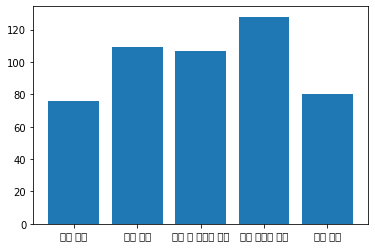

In [52]:
y = [pred_list.count(i) for i in range(5)]

plt.figure()
plt.bar(label_names, y)
plt.show()